Based on this tutorial https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/


# U-Net Architecture Overview

The U-Net architecture (see Figure 1) follows an encoder-decoder cascade structure,
where the encoder gradually compresses information into lower-dimensional representation.
Then the decoder decodes this information back to the original image dimension. Owing to this,
the architecture gets an overall U-shape, which leads to the name U-Net.


In [1]:
import os

# import the necessary packages
import torch

# base path of the dataset
TMP_DIR = '/projects/bachelor-thesis/tmp'
DATASET_PATH = os.path.join(TMP_DIR, "dataset")

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")

# define the test split:
# the fraction of the dataset we will keep aside for the test set
TEST_SPLIT = 0.15

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

print(f"Using device: {DEVICE}")
print(f"Pin memory: {PIN_MEMORY}")

Using device: cuda
Pin memory: True


In [2]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3  # as for now we are using RGB images
NUM_CLASSES = 4  # we have background, snow and clouds
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 64

# define the input image dimensions
IMAGE_SIZE = 128

# define threshold to filter weak predictions
THRESHOLD = 0.4

# Number of channels used to encode the grayscale image
NUM_ENCODED_CHANNELS = 5

# define the path to the base output directory
BASE_OUTPUT = "output"
!mkdir -p $TMP_DIR / $BASE_OUTPUT

Unique values in the mask: [0 1 2]


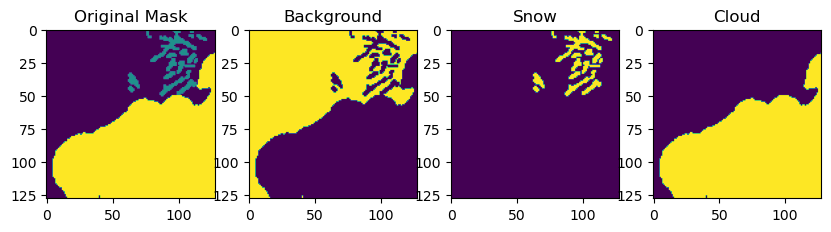

Shapes of the masks: (128, 128), (128, 128), (128, 128), (128, 128)


In [3]:
# load a demo mask
import cv2
import matplotlib.pyplot as plt
import numpy as np

# load the mask and split it into its individual channels
mask = cv2.imread(os.path.join(MASK_DATASET_PATH, "14.png"), cv2.IMREAD_UNCHANGED)
mask = mask.astype(int)
mask = mask * NUM_ENCODED_CHANNELS // 255
print(f"Unique values in the mask: {np.unique(mask)}")

background = cv2.inRange(mask, 0, 0)
snow = cv2.inRange(mask, 1, 1)
cloud = cv2.inRange(mask, 2, 2)
water = cv2.inRange(mask, 3, 3)

# plot the original mask and each of its channels
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(mask)
ax[0].set_title("Original Mask")

ax[1].imshow(background)
ax[1].set_title("Background")

ax[2].imshow(snow)
ax[2].set_title("Snow")

ax[3].imshow(cloud)
ax[3].set_title("Cloud")

plt.show()

print(f"Shapes of the masks: {background.shape}, {snow.shape}, {cloud.shape}, {water.shape}")

In [4]:
# all PyTorch datasets must inherit from this base dataset class.
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):

    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths

        # this is a set of transformations that will be applied to the image and mask
        self.transforms = transforms

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.maskPaths)

    def __getitem__(self, idx):
        """

        :param idx: index of the image to be loaded
        :return: the corresponding sample from the dataset
        """

        # grab the image path from the current index
        image_path = self.imagePaths[idx]

        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        # as by default, OpenCV loads an image in the BGR format
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # load the corresponding ground-truth segmentation mask in grayscale mode
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_UNCHANGED)

        mask = mask.astype(int)
        mask = mask * NUM_ENCODED_CHANNELS // 255

        masks = [None] * NUM_CLASSES
        for cid in range(NUM_CLASSES):
            masks[cid] = cv2.inRange(mask, cid, cid)

        masks = np.stack(masks, axis=-1)

        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            masks = self.\
                transforms(masks)

        # return a tuple of the image and its mask
        return image, masks

## Building Our U-Net Model in PyTorch

In [5]:
# import the necessary packages
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
import torch.nn.functional as functional

/home/pucyril/miniconda3/envs/bachelor_thesis/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [6]:
# Next, we define a Block module as the building unit of our encoder and decoder architecture.
# It is worth noting that all models or model sub-parts that we define are required to inherit
# from the PyTorch Module class, which is the parent class in PyTorch for all neural network modules.

class Block(Module):

    def __init__(self, inChannels, outChannels):
        super().__init__()

        # store the convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)

    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

In [7]:
class Encoder(Module):

    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()

        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)]
        )

        self.pool = MaxPool2d(2)

    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []

        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)

        # return the list containing the intermediate outputs
        return blockOutputs

In [8]:
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()

        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
             for i in range(len(channels) - 1)]
        )

        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)]
        )

    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)

            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)

        # return the final decoder output
        return x

    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)

        # return the cropped features
        return encFeatures

In [9]:
class UNet(Module):

    def __init__(self, encChannels=(3, 16, 32, 64),
                 decChannels=(64, 32, 16),
                 nbClasses=NUM_CLASSES, retainDim=True,
                 outSize=(IMAGE_SIZE, IMAGE_SIZE)):
        super().__init__()

        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)

        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)

        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
                                   encFeatures[::-1][1:])

        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)

        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = functional.interpolate(map, self.outSize)

        # return the segmentation map
        return map

## Training Our Segmentation Model

In [29]:
import torchvision
# USAGE
# python train.py
# import the necessary packages
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
import torch
import os

# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# define transformations
transforms = transforms.Compose([
    transforms.ToPILImage(),
    # resize is not needed as we are using a pretrained model
    # transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.12), ratio=(0.3, 3.3), value=0, inplace=False),
])

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=os.cpu_count())

[INFO] found 870 examples in the training set...
[INFO] found 154 examples in the test set...


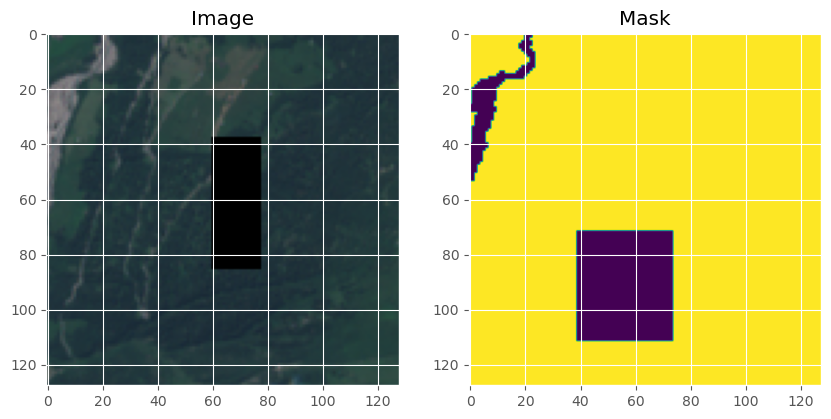

In [31]:
from matplotlib.patches import Patch
from matplotlib import pyplot as plt

# show a sample image and mask
sample = next(iter(trainLoader))

img = sample[0][0].permute(1, 2, 0)
masks = sample[1][0].permute(1, 2, 0)

# use matplotlib to display the image and mask
# show a legend for the mask next to the image
# i.g. blue = snow, green = clouds, red = water
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title("Image")

ax[1].imshow(masks[:, :, 0])
ax[1].set_title("Mask")

plt.show()

In [32]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

# initialize our UNet model
unet = UNet().to(DEVICE)

# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [33]:
from tqdm import tqdm
import time

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    unet.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)

        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss so far
        totalTrainLoss += loss

    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()

        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] training the network...


 10%|█         | 1/10 [00:04<00:37,  4.21s/it]

[INFO] EPOCH: 1/10
Train loss: 0.630036, Test loss: 0.4996


 20%|██        | 2/10 [00:08<00:32,  4.12s/it]

[INFO] EPOCH: 2/10
Train loss: 0.287258, Test loss: 0.3268


 30%|███       | 3/10 [00:12<00:28,  4.06s/it]

[INFO] EPOCH: 3/10
Train loss: 0.223109, Test loss: 0.3069


 40%|████      | 4/10 [00:16<00:24,  4.02s/it]

[INFO] EPOCH: 4/10
Train loss: 0.224650, Test loss: 0.3024


 50%|█████     | 5/10 [00:20<00:20,  4.02s/it]

[INFO] EPOCH: 5/10
Train loss: 0.214684, Test loss: 0.3052


 60%|██████    | 6/10 [00:24<00:16,  4.05s/it]

[INFO] EPOCH: 6/10
Train loss: 0.215184, Test loss: 0.3089


 70%|███████   | 7/10 [00:28<00:12,  4.05s/it]

[INFO] EPOCH: 7/10
Train loss: 0.212037, Test loss: 0.3035


 80%|████████  | 8/10 [00:32<00:08,  4.05s/it]

[INFO] EPOCH: 8/10
Train loss: 0.209058, Test loss: 0.2920


 90%|█████████ | 9/10 [00:36<00:03,  3.99s/it]

[INFO] EPOCH: 9/10
Train loss: 0.210381, Test loss: 0.2905


100%|██████████| 10/10 [00:40<00:00,  4.02s/it]

[INFO] EPOCH: 10/10
Train loss: 0.207039, Test loss: 0.2914
[INFO] total time taken to train the model: 40.19s


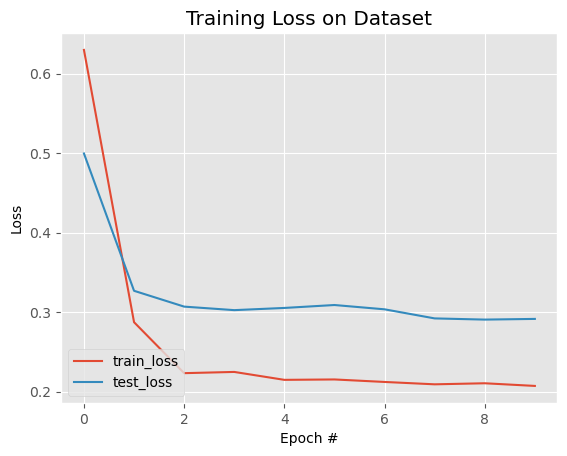

In [34]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [35]:
# import the necessary packages
import matplotlib.pyplot as plt
import torch
import os


def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

    # cmap, origMask_colorized = colorize_mask(origMask, origin="direct")
    # _, predMask_colorized = colorize_mask(predMask, origin="direct")

    # create a legend for the mask

    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)

    ax[2].imshow(predMask[0, :, :])
    ax[3].imshow(predMask[1, :, :])
    ax[4].imshow(predMask[2, :, :])
    ax[5].imshow(predMask[3, :, :])

    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")

    ax[2].set_title("Predicted Background")
    ax[3].set_title("Predicted Snow")
    ax[4].set_title("Predicted Cloud")
    ax[5].set_title("Predicted Water")

    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [36]:
import cv2
import numpy as np


def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()

    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0

        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (128, 128))
        orig = image.copy()

        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1]
        groundTruthPath = os.path.join(MASK_DATASET_PATH, filename)

        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, cv2.IMREAD_UNCHANGED)
        gtMask = cv2.resize(gtMask, (IMAGE_SIZE, IMAGE_SIZE))

        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(DEVICE)

        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()
        predMask = predMask

        # set pixels with a value greater than 0.5 to 1, and set
        # pixels with a value less than or equal to 0.5 to 0
        predMask[predMask > THRESHOLD] = 1
        predMask[predMask <= THRESHOLD] = 0

        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...


/tmp/ipykernel_23513/4111310511.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


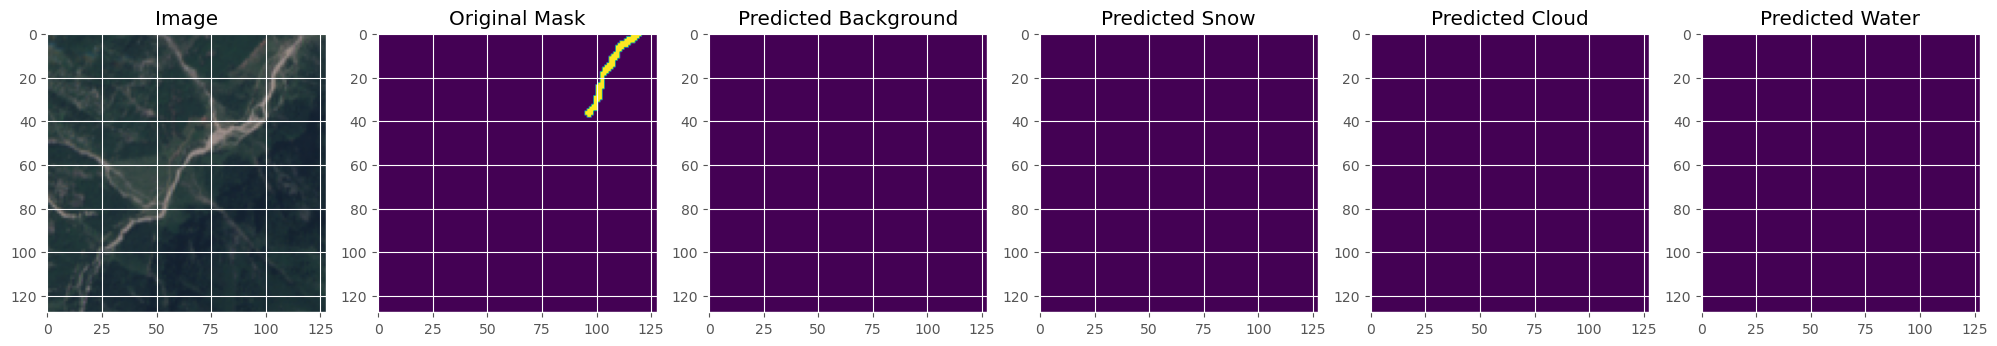

In [42]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = np.random.choice(testImages, size=1)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")

# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)